In [1]:
using Random
using Random123
using Distributions
using Plots
using StatsPlots
using StatsBase
using Statistics
using DataFrames
#using PyCall
rng_default = Xoshiro(100)
Random.seed!(rng_default, 100)

Xoshiro(0x052a102ac036e740, 0x0271411b7855150e, 0xcad97eaaad79420a, 0x379cde0a3a63c93c, 0x88075f1a254ef140)

In [5]:
"""
We now represent genotypes (with potentially different genomes) and their size
"""
mutable struct Genotype
    genotype::Unsigned # base 10 representation of the genotype (up to UInt128)
    genome::Unsigned # The binary number representing the latent/active status of each locus on the full landscape (UInt128)
    size::AbstractFloat # number of individuals with the genotype
    fitness::AbstractFloat
end

"""
Outer constructor to take arguments, calculate fitness, and instantiate a new Genotype object with that fitness
"""
function Genotype(genotype, genome, size, additive_effects, σ_epi, model)
    fitness = get_fitness(genotype, genome, additive_effects, σ_epi, model) # these parameters are passed in from the global scope
    return Genotype(genotype, genome, size, fitness)
end

"""
Generates a vector of locus-wise effects, with bounds depending on the type of calculation used for the additive fitness effects
"""
function generate_additive_effects(loci::Int)
    return rand(rng_default, Normal(0, 1), loci)
end

"""
Takes a base10 genotype, loci present in genome, and other fitness landscape params, and returns the calculated fitness value.\n
Utilizes the cbrng to efficiently and reproducibly find the fitness of a genotype on a landscape
"""
function get_fitness(genotype::UInt128, genome::UInt128, additive_effects, σ_epi, model)
    # optional to pass in some model parameters here. start with rmf: μ_add, σ_add, σ_epi, additive_effects
    rng_cbrng = ARS1x(genome) # seed the CBRNG with the genome
    if model == "rmf"
        set_counter!(rng_cbrng, genotype) # set the index of the cbrng counter to the base10 genotype (prepare to retrieve its fitness)
        μ_epi::Float64 = 0 # I believe this is default in the rmf model
        epistatic_component = rand(rng_cbrng, Normal(μ_epi, σ_epi)) # we can indeed use a random sample of the normal distribution
        additive_component = sum(digits(genome, base = 2, pad = 128) .* digits(genotype, base = 2, pad = 128) .* additive_effects) # padding now goes to 128, the maximum possible landscape size. 
        return exp(additive_component + epistatic_component)
    end
end

"""
Function to flip a bit k (from the binary representation) within a base 10 number x and return in base 10\n  
this enables us to avoid working in binary and hopefully avoid binary<>base10 conversions
"""
function flip_bit(x::T, k::Int) where T <: Unsigned
    #return (x + (-1)^(floor(x/(2^(k-1))))*2^(k-1)) # Stephan's original solution
    return x .⊻ one(T) << (k-1) # a method by left-bitshifting and xor preserves type/bitwidth
end

"""
Function to determine if, how many, and which mutants a population of genotypes/genomes will generate
"""
# we now pass in a population tuple (genotype, genome) for each in the current simulation
function generate_mutants!(population::Tuple, genotype_dictionary::Dict, current_populations::Dict, μ::AbstractFloat, M::AbstractFloat, loci::Int)
    Random.seed!(100)
    genotype::UInt128 = population[1] # renaming for readability
    genome::UInt128 = population[2]
    for i in 1:current_populations[population].size # fetch the number of individuals in this population and do for each individual:
        new_genome::UInt128 = genome # in case we need to make multiple genome mutations sequentially - this enables, potentially, backmutation
        new_genotype::UInt128 = genotype
        active_genome_bits = findall(x -> x == true, digits(new_genome, base = 2, pad = 128))
        # so now we try this for the number of active loci, not the per-individual rate
        events = [rand(rng_default, Binomial(loci, μ)), rand(rng_default, Binomial(loci, M))] # the number and type of events in the genotype and genome to simulate
        #How do we get the remaining events (mutations and expansions) to play in a random order?
        while sum(events) > 0
            mutation_type = rand(rng_default, Bernoulli(events[2]/sum(events)))[1] # generates 0 for mutations, and 1 for genome events
            if mutation_type == 1 && events[2] > 0 # if there is a genome event generated:
                new_genome = flip_bit(new_genome, rand(rng_default, 1:loci)) # there are no constraints on which loci may become active or not
                active_genome_bits = findall(x -> x == true, digits(new_genome, base = 2, pad = 128)) # and then update the active bits possible for mutations
                new_genotype *= new_genome # reset loci in the genotype to 0 if they are 0 in the genome. Otherwise fitness calc will be incorrect
                events[2] -= 1
            elseif mutation_type == 0 && events[1] > 0 && length(active_genome_bits) > 0 # else if there is a mutation event generated
                new_genotype = flip_bit(new_genotype, sample(rng_default, active_genome_bits)) # however, we must constrain the flipping of genotype bits based on which loci in the genotype are active
                events[1] -= 1
            end
        end
        if !haskey(genotype_dictionary, (new_genotype, new_genome))
            genotype_dictionary[(new_genotype, new_genome)] = Genotype(new_genotype, new_genome, 1.0, additive_effects, σ_epi, model)
            genotype_dictionary[population].size -= 1
        end
    end
    return nothing
end

"""
Function to simply calculate the hamming distance (this will probably be useful at some point)\n  
TODO: pivot to only base10 representations ([perhaps using this paper?](https://arxiv.org/pdf/1203.4547))
"""
function hamming_dist(genotype_1::BigInt, genotype_2::BigInt, loci::Int) 
    return sum(digits(genotype_1, base = 2, pad = loci) .⊻ digits(genotype_2, base = 2, pad = loci)) # xor the two
end

"""
Function to calculate the average hamming distance between <b>genotypes per genome</b> in a sample vector
"""
function average_hamming_dist(genotypes::Vector{UInt128}, loci::Int)
    n = length(genotypes) # or maybe we have to adjust this to unique genotypes? i'm not sure the situation will arise... 
    
    if n == 1 # can't compute distance between only one object
        return 0.0
    end
    
    total_distance = 0
    pair_count = 0
    # hamming distances for all pairs
    for i in 1:n
        for j in i+1:n  # only compute for unique pairs
            total_distance += sum(digits(genotypes[i], base = 2, pad = loci) .⊻ 
                                  digits(genotypes[j], base = 2, pad = loci))
            pair_count += 1
        end
    end
    return total_distance / pair_count
end

"""
Function to calculate the weighted average fitness value between all genotypes/genomes in a generation
"""
function average_fitness(genotypes::Vector{UInt128}, genomes::Vector{UInt128}, population_size, additive_effects, σ_epi, model)
    n = length(genotypes)
    total_fitness = 0
    total_population = 0

    for i in 1:n
        total_fitness += get_fitness(genotypes[i], genomes[i], additive_effects, σ_epi, model) * population_size[i]
        total_population += population_size[i]
    end

    return total_fitness / total_population
end

"""
Function to calculate the weighted average genome size between all genomes in a generation
"""
function average_genome_size(genomes::Vector{UInt128}, population_size)
    total_size = 0
    total_population = 0

    for i in 1:length(genomes)
        total_size += sum(digits(genomes[i], base = 2, pad = 128)) * population_size[i]
        total_population += population_size[i]
    end

    return total_size / total_population
end

"""
Function to apply the Heaviside step function to a number
"""
function heaviside(num::AbstractFloat)
    return 0.5 * (sign(num) + 1)
end

"""
Function to return the average expected (worst-case) time for a genotype to find a higher fitness peak\n
&emsp; i.e. we assume only one mutant is generated per timestep
"""
function expected_searchtime(l::Int64)
    x = 0
    for i in 1:l # calculates H_l, the l-th harmonic number
        x += 1/i
    end
    expectation = x *= l
    stdev = sqrt(((π^2 * l^2)/6)-expectation)
    return expectation, stdev # the expectations of this is then l * H_l 
end

expected_searchtime

In [33]:
# Initializing all our relevant parameters
loci = 6 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
init_active_loci = 2 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
max_init_genotype_bits = 1 # makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
num_genotypes = 1
σ_epi::Float64 = 1 # standard deviation of the epistatic effects
μ = (total_population^-1)#/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit higher
M = μ#*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 200000
model = "rmf"
Random.seed!(rng_default, 100) # makes the generation of additive effects reproducible
additive_effects = generate_additive_effects(128) # we will always need to generate the full range of additive effects (128 bit)
genotype_dictionary = Dict{Tuple, Genotype}() # keys are stored as a tuple of the genotype(integer) and its genome, and the genotype object as values
df_genotypes = DataFrame(Step = 0) # tracking population counts for summary metrics



# Initialize the starting genome(landscape) - this is the first seed genome
init_genome::UInt128 = 0
Random.seed!(rng_default, 100)
bits_to_flip = sample(rng_default, 1:loci, init_active_loci, replace = false) # generate a vector of unique loci to unlock at start, limited to within l total loci
for locus in bits_to_flip
    init_genome = flip_bit(init_genome, locus) # flip them, while retaining UInt128 - this is important as to not lose any information about the latent genome space!
end
println("Initial Genome: ", init_genome, " \n\t with active bits:", bits_to_flip)

# Initialize genotypes on the landscape
for i in 1:num_genotypes
    # we need a new way of generating random genotypes on a restricted landscape
    Random.seed!(rng_default, 100) # makes the generation of initial genotypes reproducible
    init_genotype::UInt128 = 0 # assume it exists as a 128bit, since it's the max size and it gets cast to this in the cbrng anyway
    for locus in sample(rng_default, bits_to_flip[1:max_init_genotype_bits], rand(rng_default, 0:max_init_genotype_bits), replace = false)  # generate a *random number* of bits that are active in the initial genome to be flipped
        init_genotype = flip_bit(init_genotype, locus)
    end
    (init_genotype, init_genome) ∉ keys(genotype_dictionary) ? #check for a unique genotype-genome pair and make the entry in dict if not
        genotype_dictionary[(init_genotype, init_genome)] = Genotype(init_genotype, init_genome, total_population/num_genotypes, additive_effects, σ_epi, model) : # fitness is the fourth value passed to genotype() and is initally represented as an arbitrary Int before fitness assignment in the constructor
        genotype_dictionary[(init_genotype, init_genome)].size += total_population/num_genotypes # otherwise increment the genotype that already exists
        
    if "Genotype" ∉ names(df_genotypes) # tracking population counts
        insertcols!(df_genotypes, :Genotype => init_genotype, :Genome => init_genome, :Pop => genotype_dictionary[(init_genotype, init_genome)].size, makeunique = true)
    elseif "Genotype" ∈ names(df_genotypes) && init_genotype ∉ df_genotypes[!, :Genotype]
        push!(df_genotypes, (Step = 0, Id = init_genotype, Genome = init_genome, Pop = genotype_dictionary[(init_genotype, init_genome)].size))
    elseif "Genotype" ∈ names(df_genotypes) && init_genotype ∈ df_genotypes[!, :Genotype]
        df_genotypes.Pop[df_genotypes.Id .== init_genotype] .+= total_population/num_genotypes # otherwise increment the genotype that already exists
    end
end

data = [(Symbol(key[1]), value.genome, value.size, value.fitness) for (key, value) in genotype_dictionary] # Construct dataframe out of dictionary information
df_init_landscape = sort!(DataFrame(data, [:Genotype, :Genome, :Size, :Fitness]), [:Fitness, :Size], rev = [true, true]) # sort by reversing fitness then population size values

landscape_size = string(round(big"2"^loci, sigdigits = 2))
println("Landscape Initialized:\n\tLandscape Size: ", landscape_size, "\n\tMax Additive Component: ", exp(sum(heaviside.(additive_effects[1:loci]) .* additive_effects[1:loci])), "\n\t", first(df_init_landscape, 10)) # dict.keys actually returns the hash table, not the assigned keys themselves



# Simulate
for t in 1:simulation_length
    if t % 1000 == 0
        print("\rIteration: $t")
    end

    # generate mutants
    current_populations = deepcopy(genotype_dictionary) # avoiding a mutate over iterable issue
    for population in keys(current_populations)
        generate_mutants!(population, genotype_dictionary, current_populations, μ, M, loci)
    end
        
    # reassign population sizes based on fitness
    w_bar = sum([((population.size / total_population) * population.fitness) for population in values(genotype_dictionary)])
    probability_vector = [((population.size / total_population) * (population.fitness / w_bar)) for population in values(genotype_dictionary)]
    value_vector = [population for population in keys(genotype_dictionary)] # need this to map the multinomial sampling back to genotype sizes
    #println("\n",genotype_dictionary,"\n",probability_vector)
    new_sizes = rand(rng_default, Multinomial(total_population, probability_vector)) # the new genotype sizes, obtained through multinomial sampling
    for i in 1:length(value_vector)
        # since the output from multinomial sampling is in the order of the probability vector passed in, we can index 
        # the sampling output the same as the values vector
        genotype_dictionary[value_vector[i]].size = new_sizes[i] 
    end
        
    # update dataframe and prune genotypes from dictionary
    for population in keys(genotype_dictionary)
        if genotype_dictionary[population].size == 0
            delete!(genotype_dictionary, population)
        else
            push!(df_genotypes, (Genotype = population[1], Genome = population[2], Step = t, Pop = genotype_dictionary[population].size))
        end
    end
end

data = [(Symbol(key[1]), value.genome, value.size, value.fitness) for (key, value) in genotype_dictionary]
df_final_landscape = sort!(DataFrame(data, [:Genotype, :Genome, :Size, :Fitness]), [:Fitness, :Size], rev = [true, true])

println("\n\nFinal Landscape:\n\t", df_final_landscape)
#

Initial Genome: 33 
	 with active bits:[1, 6]
Landscape Initialized:
	Landscape Size: 64.0
	Max Additive Component: 2.9901233285799145
	1×4 DataFrame
 Row │ Genotype  Genome   Size     Fitness  
     │ Symbol    UInt128  Float64  Float64  
─────┼──────────────────────────────────────
   1 │ 0              33   1000.0  0.776668
Iteration: 200000

Final Landscape:
	1×4 DataFrame
 Row │ Genotype  Genome   Size     Fitness 
     │ Symbol    UInt128  Float64  Float64 
─────┼─────────────────────────────────────
   1 │ 1              41   1000.0  23.2106


In [34]:
# obtaining cumulative genotype/genomes over time. Can calculate burstiness from this.
genotype_counts = countmap(df_genotypes.Step) # obtain dict of counts for each time step (= number of genotype/genomes at that step)
df_counts = sort!(DataFrame([:Step => collect(keys(genotype_counts)), :Count => collect(values(genotype_counts))]), :Step) # make into a dataframe and sort by step
unique_counts = countmap(unique(df_genotypes, [:Genotype, :Genome]).Step) # do the same but only for unique (non-previously appearing) genotype/genomes
df_unique_counts = sort!(DataFrame([:Step => collect(keys(unique_counts)), :Count => collect(values(unique_counts))]), :Step)
df_full_steps = DataFrame(Step = minimum(df_unique_counts.Step):maximum(df_counts.Step))
leftjoin!(df_full_steps, df_unique_counts, on = :Step)
df_full_steps[!, :Count] = coalesce.(df_full_steps.Count, 0)
df_full_steps[!, :Cumulative] = cumsum(df_full_steps.Count) # calculate the cumulative sum over Count
mu = round(μ, sigdigits = 3)
big_M = round(M, sigdigits = 3)
plot_c1r1 = plot(df_counts.Step, df_full_steps.Cumulative, legend = false, title = "Cumulative Unique Genotype/Genome Pairs")

# calculating extant genotype/genome richness over time
#plot_c2r1 = plot(df_counts[1:end, :Step], df_counts[1:end,:Count], ylim = (1, maximum(df_counts[!,:Count])), legend = false, title = "Extant genotype/genome pairs", color = :green)  # extant genotype/genome pairs

# calculating the population weighted average fitness over time
df_avg_fitness = combine(groupby(df_genotypes, :Step), [:Genotype, :Genome, :Pop] => ((x, y, z) -> log10(average_fitness(collect(x), collect(y), collect(z), additive_effects, σ_epi, model))) => :AverageFitness)
plot_c1r2 = plot(df_avg_fitness[1:end, :Step], df_avg_fitness[1:end, :AverageFitness], title = "Log Weighted Average Fitness", ylim = (0, maximum(df_avg_fitness[!, :AverageFitness])), legend = false, color = :red)

# calculating the population weighted average genome size over time
df_genome_size_pnine = combine(groupby(df_genotypes, :Step), [:Genome, :Pop] => ((x,y) -> average_genome_size(collect(x),collect(y))) => :AverageGenomeSize)
plot_c1r3 = plot(df_genome_size_pnine[1:end, :Step], df_genome_size_pnine[1:end, :AverageGenomeSize], title = "Weighted Average Genome Size", legend = false, color = :purple)

# need new plots to represent genome and genotype diversity
#df_hamming_diversity = combine(groupby(df_genotypes, [:Step, :Genome]), :Genotype => (group -> average_hamming_dist(collect(group), loci)) => :AverageHammingDistance)
#df_per_genome_hamming = combine(groupby(df_hamming_diversity, :Step), :AverageHammingDistance => (x -> mean(collect(x))) => :PerGenomeHammingDist)
#plot_c1r3 = plot(df_hamming_diversity[1:end,:Step], df_hamming_diversity[1:end, :AverageHammingDistance], title = "Average Hamming Distance", ylim = (0, maximum(df_hamming_diversity[!,:AverageHammingDistance])), legend = false, color = :darkorange) # average hamming dist
df_genotype_counts = combine(groupby(df_genotypes, [:Step, :Genome]), :Genotype => (x -> length(collect(x))) => :GenotypeRichness, :Pop => (y -> sum(collect(y))) => :Pop)
df_per_genome_genotypes = combine(groupby(df_genotype_counts, [:Step]), [:GenotypeRichness, :Pop] => ((x,y) -> (sum(collect(x) .* collect(y))/sum(collect(y)))) => :AvgGenotypeRichness) # shannon index alpha diversity between genomes
plot_c2r2 = plot(df_per_genome_genotypes[!,:Step], df_per_genome_genotypes[!,:AvgGenotypeRichness], label = false, color = :darkorange, title = "Alpha Diversity (Shannon Index) Per Genome")

# calculating the total number of genomes over time
df_genome_counts = combine(groupby(df_genotypes, [:Step]), :Genome => (x -> length(unique(collect(x)))) => :GenomeRichness)
plot_c2r3 = plot(df_genome_counts[1:end,:Step], df_genome_counts[1:end, :GenomeRichness], title = "Genome Richness", ylim = (1, maximum(df_genome_counts[!,:GenomeRichness])), legend = false, color = :pink)

plot_c2r1 = plot(df_genome_counts[!,:Step], log.(df_per_genome_genotypes[!,:AvgGenotypeRichness]./df_genome_counts[!,:GenomeRichness]), label = false, title = "Log-ratio Genotype:Genome Richness", color = :green)

plot(plot_c1r1, plot_c2r1, plot_c1r2, plot_c2r2, plot_c1r3, plot_c2r3, plot_title = "l: $loci, σ_e: $σ_epi, μ: $mu, M = $big_M, pop: $total_population", layout = (3,2))
plot!(size = (1000,1000))
png("L$loci\\_l$init_active_loci\\_i$max_init_genotype_bits\\_equal_mutation.png")


"L6\\_l2\\_i1\\_equal_mutation.png"

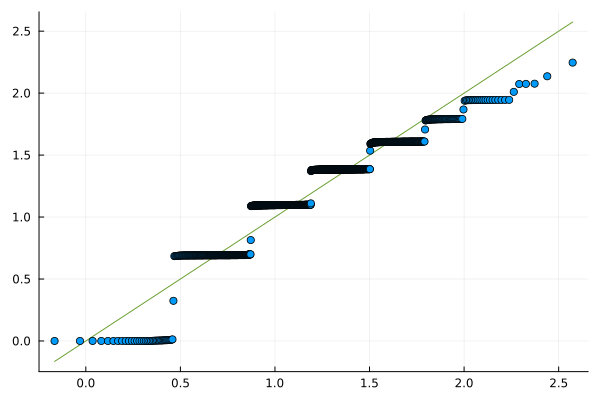

In [77]:
# in order to run cross correlations, we need to normalize the time series. are the data normally distributed?
test_1 = histogram(df_per_genome_genotypes[!,:AvgGenotypeRichness], bins = 10)
log_transform = log.(df_per_genome_genotypes[!,:AvgGenotypeRichness])
log_norm = (log_transform .- mean(log_transform)) ./ std(log_transform)
test_2 = histogram(log_norm, bins = 6)
test_3 = qqplot(Normal(mean(log_transform),std(log_transform)), log_transform)
plot(test_3, layout = (1,3))